# Segmentación de Empleados de la Contraloría General de la República Dominicana (2018-2025)

**Objetivo:** Identificar grupos naturales de empleados según sueldo, estatus, función, departamento, nivel de departamento y sexo. Se incluye edad como variable adicional para enriquecer el análisis.

**Autores:** Scarlet Abreu y Renso Peralta

#### Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline

#### Cargar el dataset

In [9]:
df = pd.read_csv("C:\\Users\\Scarlet\\Downloads\\DW_CGR_ETL\\merged_empleados.csv")

#### Mostrar las primeras filas y Resumen estadístico

En esta celda se muestra las 5 primeras filas del dataset, un resumen estadístico, la información general, los valores nulos y la cantidad de empleados únicos.

In [10]:
print("Primeras filas del dataset:")
print(df.head())
print("\nResumen estadístico:")
print(df.describe())
print("\nInformación general:")
print(df.info())
print("\nValores nulos:")
print(df.isnull().sum())
print("\nNúmero de empleados únicos:")
print(df['EMPLEADO_ID'].nunique())

Primeras filas del dataset:
   EMPLEADO_ID  DEPARTAMENTO_ID  FUNCION_ID  ESTATUS_ID  MES_ID    SUELDO  \
0            1                1           1           1       1   45000.0   
1            2                1           2           2       1  150000.0   
2            3                1           3           1       1  100000.0   
3            4                1           4           2       1   90000.0   
4            5                1           1           1       1   45000.0   

                   NOMBRE_EMPLEADO  EDAD       SEXO  \
0             DOMINGO LUISOR ARIAS  48.0  MASCULINO   
1              ERASMO DURAN BELTRE  61.0  MASCULINO   
2       MOHAMED PLACIDO MARMOLEJOS  37.0  MASCULINO   
3          MARTHA NOEMI DIAZ NUÑEZ  52.0   FEMENINO   
4  PEDRO NAPOLEON HERNANDEZ CASADO  58.0  MASCULINO   

                       NOMBRE_DEPARTAMENTO NIVEL_DEPARTAMENTO  \
0  DIRECCION UNIDADES DE AUDITORIA INTERNA               ALTO   
1  DIRECCION UNIDADES DE AUDITORIA INTERNA      

#### Histograma

Los histogramas muestran cómo se distribuyen los valores de sueldo y edad dentro del conjunto de datos, permitiendo identificar rangos comunes y posibles valores fuera de lo normal. La curva KDE ayuda a visualizar la forma general de la distribución.

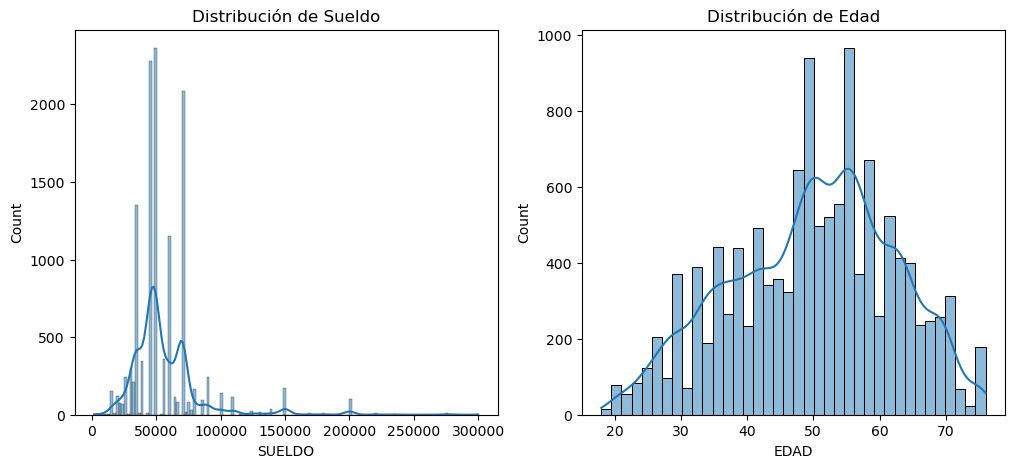

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['SUELDO'], kde=True, ax=axs[0])
axs[0].set_title('Distribución de Sueldo')
sns.histplot(df['EDAD'], kde=True, ax=axs[1])
axs[1].set_title('Distribución de Edad')
plt.show()

#### Conteos de variables categóricas

Los gráficos de conteo permiten observar la frecuencia de cada categoría en nivel de departamento y sexo, mostrando cómo se distribuyen estas clasificaciones entre los empleados. Esto ayuda a detectar desbalances o patrones dentro de las variables categóricas.

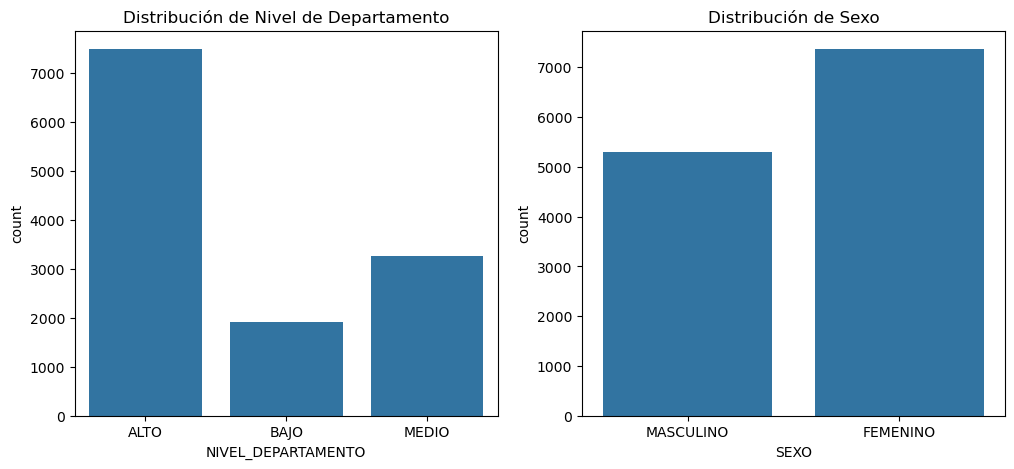

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='NIVEL_DEPARTAMENTO', data=df, ax=axs[0])
axs[0].set_title('Distribución de Nivel de Departamento')
sns.countplot(x='SEXO', data=df, ax=axs[1])
axs[1].set_title('Distribución de Sexo')
plt.show()

#### Matríz de correlación

La matriz de correlación revela la intensidad de la relación entre las variables numéricas del dataset. Este análisis facilita identificar qué variables están más asociadas entre sí para futuros modelos o decisiones analíticas.

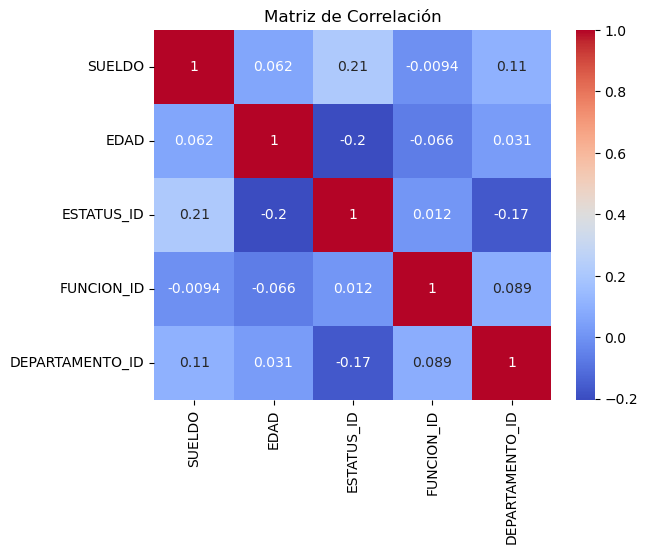

In [38]:
corr = df[['SUELDO', 'EDAD', 'ESTATUS_ID', 'FUNCION_ID', 'DEPARTAMENTO_ID']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

#### Preprocesamiento

El preprocesamiento realiza una agregación por empleado, combinando todos los registros repetidos de un mismo EMPLEADO_ID y dejando un único registro por persona. Para lograrlo, se calcula el promedio en las variables numéricas y se conserva el primer valor en las categóricas, eliminando además columnas que ya no son necesaria

In [39]:
# Agregar datos por EMPLEADO_ID
df_unique = df.groupby('EMPLEADO_ID').agg({
    'SUELDO': 'mean',
    'EDAD': 'mean',
    'ESTATUS_ID': 'first',
    'FUNCION_ID': 'first',
    'DEPARTAMENTO_ID': 'first',
    'NIVEL_DEPARTAMENTO': 'first',
    'SEXO': 'first'
}).reset_index()

# Eliminar columnas innecesarias
df_unique.drop(columns=['EMPLEADO_ID'], inplace=True)

print("Dataset agregado:")
print(df_unique.head())

Dataset agregado:
          SUELDO  EDAD  ESTATUS_ID  FUNCION_ID  DEPARTAMENTO_ID  \
0   55984.042553  48.0           1           1                1   
1  124166.666667  61.0           2           2                1   
2  100000.000000  37.0           1           3                1   
3   94545.454545  52.0           2           4                1   
4   43000.000000  58.0           1           1                1   

  NIVEL_DEPARTAMENTO       SEXO  
0               ALTO  MASCULINO  
1               ALTO  MASCULINO  
2               ALTO  MASCULINO  
3               ALTO   FEMENINO  
4               ALTO  MASCULINO  


#### Variables seleccionadas para clustering

Se seleccionaron las variables numéricas sueldo y edad, junto con varias variables categóricas relacionadas con estatus, función, departamento, nivel y sexo, como material para el modelo de clustering. Estas características permiten representar tanto información cuantitativa como cualitativa del empleado, facilitando una segmentación más completa y significativa.

In [40]:
num_features = ['SUELDO', 'EDAD']
cat_features = ['ESTATUS_ID', 'FUNCION_ID', 'DEPARTAMENTO_ID', 'NIVEL_DEPARTAMENTO', 'SEXO']

#### Preparación de Datos

Este proceso aplica un escalado a las variables numéricas y una codificación One-Hot a las variables categóricas, asegurando que todas las características estén en un formato adecuado para el algoritmo de clustering. Con este preprocesamiento, el modelo puede interpretar correctamente tanto valores continuos como categorías sin introducir sesgos por diferencias de escala.

In [29]:
# Transformador para numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ])

# Aplicar preprocesamiento
X = preprocessor.fit_transform(df_unique)
print(f"Forma de X después de preprocesamiento: {X.shape}")

Forma de X después de preprocesamiento: (720, 86)


#### Reducción de Dimensionalidad

El uso de PCA permite reducir la gran cantidad de variables generadas por la codificación One-Hot, concentrando la información más importante en un menor número de componentes principales. Al retener el 95% de la varianza, se mantiene casi toda la información relevante mientras se simplifica el espacio de datos para mejorar el rendimiento del clustering.

In [30]:
pca = PCA(n_components=0.95)  # Retener 95% de varianza
X_pca = pca.fit_transform(X)
print(f"Forma de X después de PCA: {X_pca.shape}")
print(f"Varianza explicada: {pca.explained_variance_ratio_.sum()}")

Forma de X después de PCA: (720, 26)
Varianza explicada: 0.9511905673200806


#### Determinar el número de clusters (K) con método del codo

Se evalúa el rendimiento del modelo K-Means probando diferentes valores de k y registrando tanto la inercia como el puntaje de silueta para cada uno. Luego, el método del codo se visualiza gráficamente para identificar el número ideal de clusters donde la reducción de inercia comienza a estabilizarse.

C:\Users\Scarlet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Scarlet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Scarlet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\Scarlet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak o

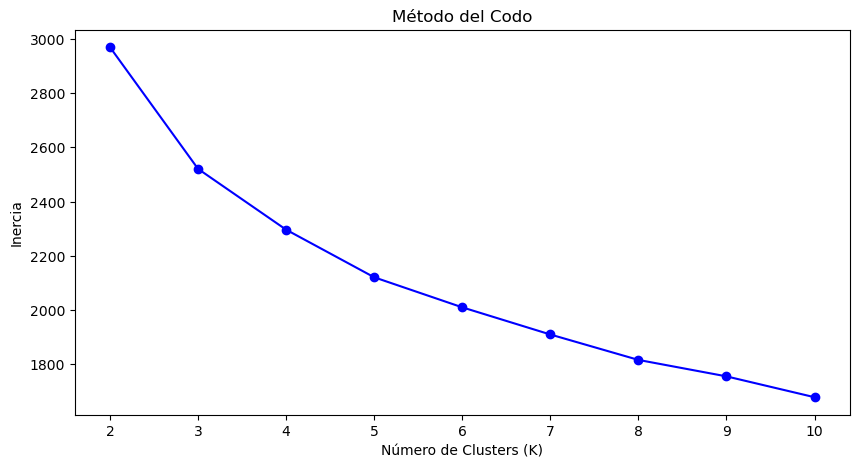

In [52]:
inertia = []
sil_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Gráfico del codo
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

#### Evaluación de clustering con silhouette score

Este gráfico muestra el puntaje de silueta para distintos valores de k, lo que permite medir qué tan bien separados y cohesionados están los clusters. Valores más altos indican una mejor separación entre grupos, ayudando a elegir el número óptimo de clusters para el modelo.

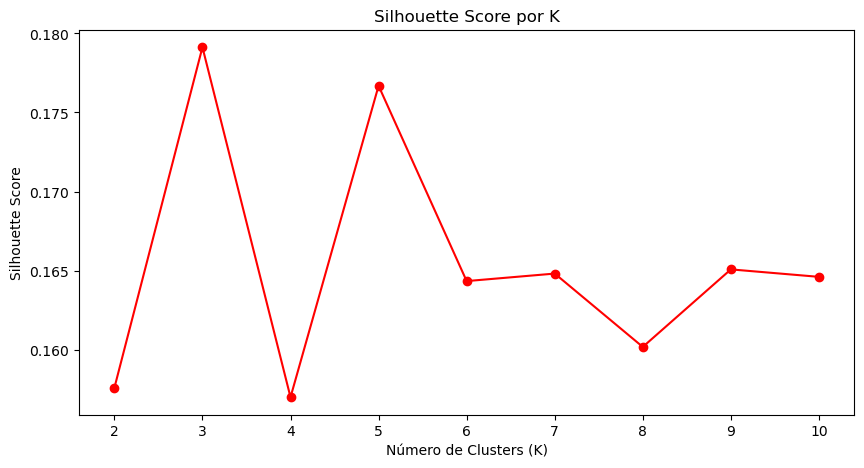

In [32]:
# Gráfico de Silhouette
plt.figure(figsize=(10, 5))
plt.plot(k_range, sil_scores, 'ro-')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por K')
plt.show()

#### Entrenamiento del modelo k-means

En este paso se entrena el modelo K-Means usando el número óptimo de clusters identificado previamente. Cada empleado se asigna a un cluster, y se calcula el Silhouette Score para evaluar la calidad de la segmentación obtenida.

In [50]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_unique['CLUSTER'] = kmeans.fit_predict(X_pca)

print(f"Silhouette Score para K={optimal_k}: {silhouette_score(X_pca, df_unique['CLUSTER'])}")

Silhouette Score para K=3: 0.17913073553346198


C:\Users\Scarlet\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


#### Visualización de clusters

Estos gráficos permiten observar cómo se distribuyen los clusters tanto en el espacio reducido por PCA como en las variables originales. La visualización ayuda a interpretar la segmentación, mostrando qué grupos de empleados comparten características similares en sueldo, edad y otras dimensiones, aunque la separación no sea completamente clara debido al Silhouette Score relativamente bajo.

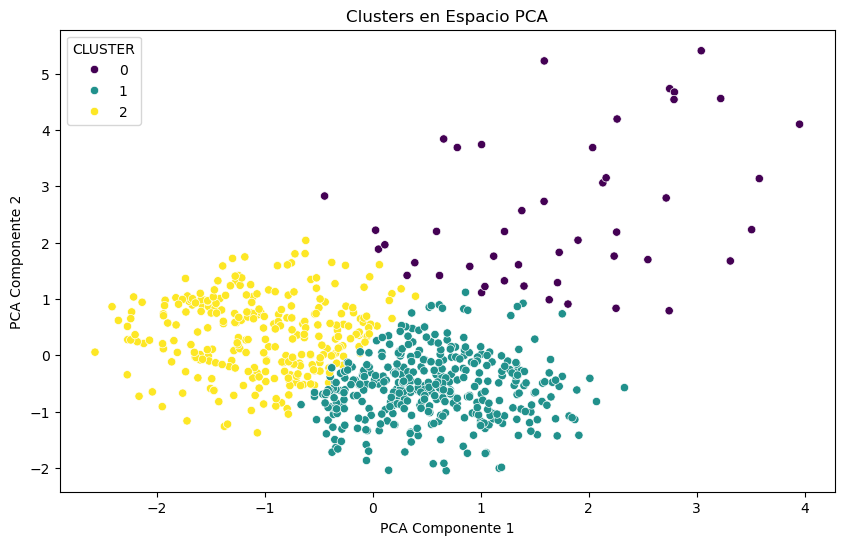

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_unique['CLUSTER'], palette='viridis')
plt.xlabel('PCA Componente 1')
plt.ylabel('PCA Componente 2')
plt.title('Clusters en Espacio PCA')
plt.show()

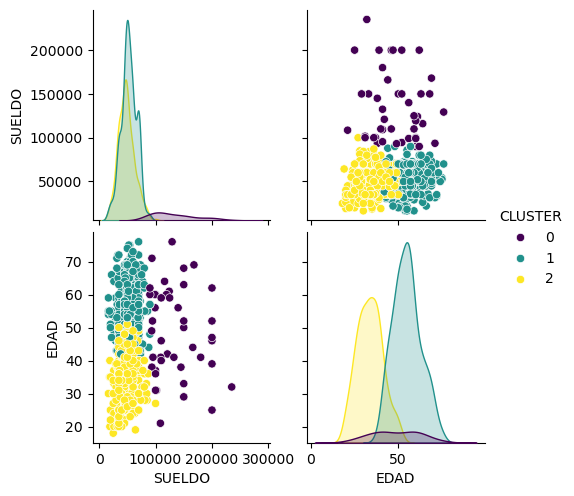

In [35]:
# Pairplot de variables originales por cluster
sns.pairplot(df_unique[['SUELDO', 'EDAD', 'CLUSTER']], hue='CLUSTER', palette='viridis')
plt.show()

In [36]:
# Medias por cluster para numéricas
print("Medias por Cluster:")
print(df_unique.groupby('CLUSTER')[num_features].mean())

Medias por Cluster:
                SUELDO       EDAD
CLUSTER                          
0        133457.194735  48.391304
1         52267.515038  54.837629
2         48097.036451  33.622378


Este análisis muestra el promedio de sueldo y edad dentro de cada cluster, lo que permite caracterizar los grupos de empleados según sus características numéricas. Así se pueden identificar patrones, como clusters con sueldos más altos o edades promedio mayores, ayudando a interpretar el significado de cada segmento.

#### Conclusión

El clustering aplicado a los empleados permitió segmentar al personal en grupos con características similares en términos de sueldo, edad, estatus, función, departamento, nivel y sexo. Aunque la separación entre clusters no es muy fuerte (Silhouette Score bajo), los análisis de medias y visualizaciones muestran diferencias interesantes que pueden servir para tomar decisiones estratégicas de recursos humanos, como identificar grupos con mayores necesidades de desarrollo, ajustar políticas salariales o diseñar planes de capacitación más específicos.